In [2]:
!pip install fastai

     |████████████████████████████████| 3.5MB 1.7MB/s eta 0:00:01
     |████████████████████████████████| 14.2MB 2.3MB/s eta 0:00:01    |                                | 40kB 5.6MB/s eta 0:00:03
     |████████████████████████████████| 645kB 1.1MB/s eta 0:00:01
     |████████████████████████████████| 122kB 774kB/s eta 0:00:01
     |████████████████████████████████| 276kB 1.5MB/s eta 0:00:01
     |████████████████████████████████| 4.0MB 1.3MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/f6/d2/40b3fa882147719744e6aa50ac39cf7a22a913cbcba86a0371176c425a3b/importlib_metadata-0.23-py2.py3-none-any.whl
     |████████████████████████████████| 3.0MB 1.4MB/s eta 0:00:01     |█████████████████████████▋      | 2.4MB 1.4MB/s eta 0:00:01
     |████████████████████████████████| 61kB 6.2MB/s eta 0:00:01
     |████████████████████████████████| 215kB 719kB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/74/3d/1ee25a26411ba0401b43c6376d2316a71addcc72ef8690b101

  Stored in directory: /Users/luoyonggui/Library/Caches/pip/wheels/e4/1d/06/640c93f5270d67d0247f30be91f232700d19023f9e66d735c7
Successfully built fastai nvidia-ml-py3
ERROR: torchvision 0.4.2 has requirement torch==1.3.1, but you'll have torch 1.1.0.post2 which is incompatible.
  Found existing installation: zipp 0.3.3
    Uninstalling zipp-0.3.3:
      Successfully uninstalled zipp-0.3.3
  Found existing installation: importlib-metadata 0.0.0
    Uninstalling importlib-metadata-0.0.0:
      Successfully uninstalled importlib-metadata-0.0.0


In [2]:
import math
import matplotlib
import numpy as np
import pandas as pd
import pickle

import plotly.graph_objs as go
import time

from collections import defaultdict
from datetime import date
from fastai.tabular import add_datepart
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

# params_init

In [3]:
# py.sign_in('<your-user-id>', '<your-api-key>') # sign in to plotly if you haven't done so

#### Input params ##################
folder = "./"
filename = "df.pkl"

# Predicting on day 1008, date 2017-01-03 00:00:00
# Predicting on day 1050, date 2017-03-06 00:00:00
# Predicting on day 1092, date 2017-05-04 00:00:00
# Predicting on day 1134, date 2017-07-05 00:00:00
# Predicting on day 1176, date 2017-09-01 00:00:00
# Predicting on day 1218, date 2017-11-01 00:00:00
# Predicting on day 1260, date 2018-01-03 00:00:00
# Predicting on day 1302, date 2018-03-06 00:00:00
# Predicting on day 1344, date 2018-05-04 00:00:00
# Predicting on day 1386, date 2018-07-05 00:00:00
# Predicting on day 1428, date 2018-09-04 00:00:00
# Predicting on day 1470, date 2018-11-01 00:00:00

pred_day = 1008                # Predict for this day, for the next H-1 days. Note indexing of days start from 0.

H = 21                         # Forecast horizon, in days. Note there are about 252 trading days in a year
train_size = 252*3             # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                 # Use 1 year of data as validation set
N = 10                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14

# Plotly colors
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]

####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 1008


In [4]:
tic1 = time.time()

# Common functions

In [5]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

## get_mov_avg_std

In [71]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

In [72]:
dff = pd.DataFrame(np.random.rand(50,2), columns=['c1', 'c2'])

In [73]:
get_mov_avg_std(dff, 'c1', 10)

,c1,c2,c1_mean,c1_std
0,0.081787,0.036603,NaN,NaN
1,0.786390,0.971592,0.081787,NaN
2,0.341092,0.515011,0.434089,0.498229
3,0.429873,0.199936,0.403090,0.356369
4,0.758144,0.505013,0.409786,0.291282
5,0.441080,0.536238,0.479457,0.296487
6,0.947339,0.713680,0.473061,0.265649
7,0.451528,0.978295,0.540815,0.301566
8,0.536086,0.935543,0.529654,0.280975
9,0.273384,0.680613,0.530369,0.262836


## do_scaling

In [ ]:
def do_scaling(df, N):
    """
    Do scaling for the adj_close and lag cols
    """
    df.loc[:, 'adj_close_scaled'] = (df['adj_close'] - df['adj_close_mean']) / df['adj_close_std']
    for n in range(N,0,-1):
        df.loc[:, 'adj_close_scaled_lag_'+str(n)] = \
            (df['adj_close_lag_'+str(n)] - df['adj_close_mean']) / df['adj_close_std']
        
        # Remove adj_close_lag column which we don't need anymore
        df.drop(['adj_close_lag_'+str(n)], axis=1, inplace=True)

    return df



## pred_xgboost

In [ ]:
def pred_xgboost(model, X_test_ex_adj_close, N, H, prev_vals, prev_mean_val, prev_std_val):
    """
    Do recursive forecasting using xgboost
    Inputs
        model              : the xgboost model
        X_test_ex_adj_close: features of the test set, excluding adj_close_scaled values 
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        prev_vals          : numpy array. If predict at time t, 
                             prev_vals will contain the N unscaled values at t-1, t-2, ..., t-N
        prev_mean_val      : the mean of the unscaled values at t-1, t-2, ..., t-N
        prev_std_val       : the std deviation of the unscaled values at t-1, t-2, ..., t-N
    Outputs
        Times series of predictions. Numpy array of shape (H,). This is unscaled.
    """
    forecast = prev_vals.copy()

    for n in range(H):
        forecast_scaled = (forecast[-N:] - prev_mean_val) / prev_std_val
        
        # Create the features dataframe
        X = X_test_ex_adj_close[n:n+1].copy()
        for n in range(N,0,-1):
            X.loc[:, "adj_close_scaled_lag_"+str(n)] = forecast_scaled[-n]
        
        # Do prediction
        est_scaled = model.predict(X)
        
        # Unscale the prediction
        forecast = np.concatenate([forecast, 
                                   np.array((est_scaled * prev_std_val) + prev_mean_val).reshape(1,)])
        
        # Comp. new mean and std
        prev_mean_val = np.mean(forecast[-N:])
        prev_std_val = np.std(forecast[-N:])
           
    return forecast[-H:]

## train_pred_eval_model

In [6]:
def train_pred_eval_model(X_train_scaled,
                          y_train_scaled,
                          X_test_ex_adj_close,
                          y_test,
                          N,
                          H,
                          prev_vals,
                          prev_mean_val,
                          prev_std_val,
                          seed=100,
                          n_estimators=100,
                          max_depth=3,
                          learning_rate=0.1,
                          min_child_weight=1,
                          subsample=1,
                          colsample_bytree=1,
                          colsample_bylevel=1,
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_ex_adj_close: features of the test set, excluding adj_close_scaled values 
        y_test             : target for test. Actual values, not scaled.
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        prev_vals          : numpy array. If predict at time t, 
                             prev_vals will contain the N unscaled values at t-1, t-2, ..., t-N
        prev_mean_val      : the mean of the unscaled values at t-1, t-2, ..., t-N
        prev_std_val       : the std deviation of the unscaled values at t-1, t-2, ..., t-N
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        mae                : mean absolute error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(objective ='reg:squarederror',
                         seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
        
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est = pred_xgboost(model, X_test_ex_adj_close, N, H, prev_vals, prev_mean_val, prev_std_val)

    # Calculate RMSE, MAPE, MAE
    rmse = get_rmse(y_test, est)
    mape = get_mape(y_test, est)
    mae = get_mae(y_test, est)
    
    return rmse, mape, mae, est, model.feature_importances_



## add_lags

In [63]:
def add_lags(df, N, lag_cols):
    """
    Add lags up to N number of days to use as features
    The lag columns are labelled as 'adj_close_lag_1', 'adj_close_lag_2', ... etc.
    """
    # Use lags up to N number of days to use as features
    df_w_lags = df.copy()
    df_w_lags.loc[:, 'order_day'] = [x for x in list(range(len(df)))] # Add a column 'order_day' to indicate the order of the rows by date
    merging_keys = ['order_day'] # merging_keys
    shift_range = [x+1 for x in range(N)]
    for shift in shift_range:
        train_shift = df_w_lags[merging_keys + lag_cols].copy()
    
        # E.g. order_day of 0 becomes 1, for shift = 1.
        # So when this is merged with order_day of 1 in df_w_lags, this will represent lag of 1.
        train_shift['order_day'] = train_shift['order_day'] + shift
    
        foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
        train_shift = train_shift.rename(columns=foo)

        df_w_lags = pd.merge(df_w_lags, train_shift, on=merging_keys, how='left') #.fillna(0)
    del train_shift
    
    return df_w_lags

## get_error_metrics

In [ ]:
def get_error_metrics(df,
                      train_size,
                      N,
                      H,
                      seed=100,
                      n_estimators=100,
                      max_depth=3,
                      learning_rate=0.1,
                      min_child_weight=1,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      gamma=0):
    """
    Given a series consisting of both train+validation, do predictions of forecast horizon H on the validation set, 
    at H/2 intervals.
    Inputs
        df                 : train + val dataframe. len(df) = train_size + val_size
        train_size         : size of train set
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 

    Outputs
        mean of rmse, mean of mape, mean of mae, dictionary of predictions
    """
    rmse_list = [] # root mean square error
    mape_list = [] # mean absolute percentage error
    mae_list = []  # mean absolute error
    preds_dict = {}
    
    # Add lags up to N number of days to use as features
    df = add_lags(df, N, ['adj_close'])
    
    # Get mean and std dev at timestamp t using values from t-1, ..., t-N
    df = get_mov_avg_std(df, 'adj_close', N)
    
    # Do scaling
    df = do_scaling(df, N)
    
    # Get list of features
    features_ex_adj_close = [
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end'
    ]
    features = features_ex_adj_close # features contain all features, including adj_close_lags
    for n in range(N,0,-1):
        features.append("adj_close_scaled_lag_"+str(n))
    
    for i in range(train_size, len(df)-H+1, int(H/2)):  # H=21  [train_size, train_size+10, ...]
        # Split into train and test
        train = df[i-train_size:i].copy()
        test = df[i:i+H].copy()
    
        # Drop the NaNs in train
        train.dropna(axis=0, how='any', inplace=True)
    
        # Split into X and y
        X_train_scaled = train[features]
        y_train_scaled = train['adj_close_scaled']
        X_test_ex_adj_close = test[features_ex_adj_close]
        y_test = test['adj_close']
        prev_vals = train[-N:]['adj_close'].to_numpy()
        prev_mean_val = test.iloc[0]['adj_close_mean']
        prev_std_val = test.iloc[0]['adj_close_std']
            
        rmse, mape, mae, est, _ = train_pred_eval_model(X_train_scaled,
                                                        y_train_scaled,
                                                        X_test_ex_adj_close,
                                                        y_test,
                                                        N,
                                                        H,
                                                        prev_vals,
                                                        prev_mean_val,
                                                        prev_std_val,
                                                        seed=seed,
                                                        n_estimators=n_estimators,
                                                        max_depth=max_depth,
                                                        learning_rate=learning_rate,
                                                        min_child_weight=min_child_weight,
                                                        subsample=subsample,
                                                        colsample_bytree=colsample_bytree,
                                                        colsample_bylevel=colsample_bylevel,
                                                        gamma=gamma)
#         print("N = " + str(N) + ", i = " + str(i) + ", rmse = " + str(rmse) + ", mape = " + str(mape) + ", mae = " + str(mae))
        
        rmse_list.append(rmse)
        mape_list.append(mape)
        mae_list.append(mae)
        preds_dict[i] = est
    
    return np.mean(rmse_list), np.mean(mape_list), np.mean(mae_list), preds_dict 

def get_error_metrics_one_pred(df,
                               train_size,
                               N,
                               H,
                               seed=100,
                               n_estimators=100,
                               max_depth=3,
                               learning_rate=0.1,
                               min_child_weight=1,
                               subsample=1,
                               colsample_bytree=1,
                               colsample_bylevel=1,
                               gamma=0):
    """
    Given a series consisting of both train+test, do one prediction of forecast horizon H on the test set.
    Inputs
        df                 : train + test dataframe. len(df) = train_size + test_size
        train_size         : size of train set
        N                  : for feature at day t, we use lags from t-1, t-2, ..., t-N as features
        H                  : forecast horizon
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 

    Outputs
        rmse, mape, mae, predictions
    """    
    # Add lags up to N number of days to use as features
    df = add_lags(df, N, ['adj_close'])
    
    # Get mean and std dev at timestamp t using values from t-1, ..., t-N
    df = get_mov_avg_std(df, 'adj_close', N)
    
    # Do scaling
    df = do_scaling(df, N)
    
    # Get list of features
    features_ex_adj_close = [
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end'
    ]
    features = features_ex_adj_close # features contain all features, including adj_close_lags
    for n in range(N,0,-1):
        features.append("adj_close_scaled_lag_"+str(n))
    
    # Split into train and test
    train = df[:train_size].copy()
    test = df[train_size:train_size+H].copy()
    
    # Drop the NaNs in train
    train.dropna(axis=0, how='any', inplace=True)
    
    # Split into X and y
    X_train_scaled = train[features]
    y_train_scaled = train['adj_close_scaled']
    X_test_ex_adj_close = test[features_ex_adj_close]
    y_test = test['adj_close']
    prev_vals = train[-N:]['adj_close'].to_numpy()
    prev_mean_val = test.iloc[0]['adj_close_mean']
    prev_std_val = test.iloc[0]['adj_close_std']
            
    rmse, mape, mae, est, feature_importances = train_pred_eval_model(X_train_scaled,
                                                                      y_train_scaled,
                                                                      X_test_ex_adj_close,
                                                                      y_test,
                                                                      N,
                                                                      H,
                                                                      prev_vals,
                                                                      prev_mean_val,
                                                                      prev_std_val,
                                                                      seed=seed,
                                                                      n_estimators=n_estimators,
                                                                      max_depth=max_depth,
                                                                      learning_rate=learning_rate,
                                                                      min_child_weight=min_child_weight,
                                                                      subsample=subsample,
                                                                      colsample_bytree=colsample_bytree,
                                                                      colsample_bylevel=colsample_bylevel,
                                                                      gamma=gamma)
    
    return rmse, mape, mae, est, feature_importances, features

# Load data

In [7]:
df = pd.read_pickle(folder+filename)
df.head()

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2014-01-02,600115.SH,2.79,2.79,2.74,2.75,2.77,-0.02,-0.72,71086.05,19618.296
2014-01-03,600115.SH,2.74,2.75,2.68,2.70,2.75,-0.05,-1.82,99269.74,26843.520
2014-01-06,600115.SH,2.70,2.70,2.58,2.60,2.70,-0.10,-3.70,149697.16,39048.662
2014-01-07,600115.SH,2.59,2.66,2.58,2.61,2.60,0.01,0.38,75141.68,19638.304
2014-01-08,600115.SH,2.62,2.64,2.58,2.60,2.61,-0.01,-0.38,67810.19,17638.616


In [8]:
df['date'] = df.index
df.drop(columns=['change', 'amount', 'pct_chg', 'ts_code'], inplace=True)
df.rename(columns={'close': 'adj_close', 'pre_close': 'close', 'vol': 'volume'}, inplace=True)

In [9]:
df.head(1)

,open,high,low,adj_close,close,volume,date
trade_date,,,,,,,
2014-01-02,2.79,2.79,2.74,2.75,2.77,71086.05,2014-01-02


In [10]:
# Remove columns which you can't use as features
df.drop(['open', 'high', 'low', 'close', 'volume'], axis=1, inplace=True)

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



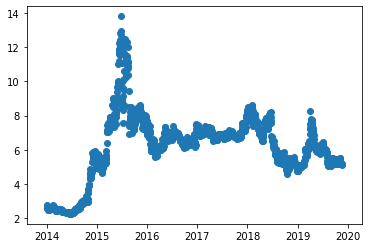

In [11]:
plt.scatter(x = df['date'],
            y = df['adj_close'],)

# Feature Engineering

In [12]:
df.head()

,adj_close,date
trade_date,,
2014-01-02,2.75,2014-01-02
2014-01-03,2.70,2014-01-03
2014-01-06,2.60,2014-01-06
2014-01-07,2.61,2014-01-07
2014-01-08,2.60,2014-01-08


In [13]:
#create features
add_datepart(df, 'date', drop=False)
df.drop('Elapsed', axis=1, inplace=True)  # don't need this
df.head(50)

,adj_close,date,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
trade_date,,,,,,,,,,,,,,
2014-01-02,2.75,2014-01-02,2014,1,1,2,3,2,False,False,False,False,False,False
2014-01-03,2.70,2014-01-03,2014,1,1,3,4,3,False,False,False,False,False,False
2014-01-06,2.60,2014-01-06,2014,1,2,6,0,6,False,False,False,False,False,False
2014-01-07,2.61,2014-01-07,2014,1,2,7,1,7,False,False,False,False,False,False
2014-01-08,2.60,2014-01-08,2014,1,2,8,2,8,False,False,False,False,False,False
2014-01-09,2.58,2014-01-09,2014,1,2,9,3,9,False,False,False,False,False,False
2014-01-10,2.50,2014-01-10,2014,1,2,10,4,10,False,False,False,False,False,False
2014-01-13,2.51,2014-01-13,2014,1,3,13,0,13,False,False,False,False,False,False
2014-01-14,2.53,2014-01-14,2014,1,3,14,1,14,False,False,False,False,False,False


In [14]:
# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

In [15]:
# Convert year to categorical feature, based on alphabetical order
df.loc[:, 'year'] = LabelEncoder().fit_transform(df['year'])
df[15:25]

,adj_close,date,year,month,week,day,dayofweek,dayofyear,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
trade_date,,,,,,,,,,,,,,
2014-01-23,2.58,2014-01-23,0,1,4,23,3,23,False,False,False,False,False,False
2014-01-24,2.60,2014-01-24,0,1,4,24,4,24,False,False,False,False,False,False
2014-01-27,2.57,2014-01-27,0,1,5,27,0,27,False,False,False,False,False,False
2014-01-28,2.59,2014-01-28,0,1,5,28,1,28,False,False,False,False,False,False
2014-01-29,2.57,2014-01-29,0,1,5,29,2,29,False,False,False,False,False,False
2014-01-30,2.53,2014-01-30,0,1,5,30,3,30,False,False,False,False,False,False
2014-02-07,2.54,2014-02-07,0,2,6,7,4,38,False,False,False,False,False,False
2014-02-10,2.60,2014-02-10,0,2,7,10,0,41,False,False,False,False,False,False
2014-02-11,2.62,2014-02-11,0,2,7,11,1,42,False,False,False,False,False,False


# EDA
探索性数据分析（EDA）

EDA是机器学习项目的重要组成部分，它可以帮助我们获得对数据集的良好“感知”。正如我们将在下面看到的，EDA过程涉及到创建可视化来帮助大家更好地理解数据集。



In [16]:
# Count number of nulls for each column
df.isnull().sum(axis=0)

adj_close           0
date                0
year                0
month               0
week                0
day                 0
dayofweek           0
dayofyear           0
is_month_end        0
is_month_start      0
is_quarter_end      0
is_quarter_start    0
is_year_end         0
is_year_start       0
dtype: int64

下图显示了每个月复权收盘价均值。可以根据数据集推断，就平均值而言，后几个月的值比前几个月的值高。

In [17]:
# Compute the average price for each month
avg_price_mth = df.groupby("month").agg({'adj_close': 'mean'}).reset_index()

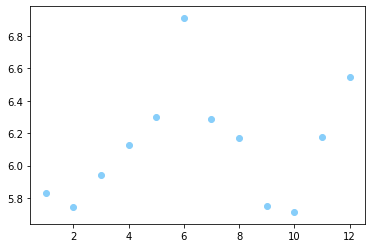

In [18]:
plt.scatter(x = avg_price_mth['month'],
            y = avg_price_mth['adj_close'],c='LightSkyBlue')

下面的图显示了该月复权收盘价每一天均值。平均而言，有一个向上倾斜的趋势，即月底的价格高于前几天。

In [19]:
# Compute the average price for each day of month
avg_price_day = df.groupby("day").agg({'adj_close': 'mean'}).reset_index()

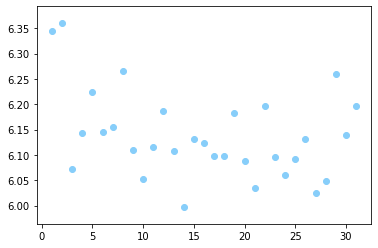

In [20]:
plt.scatter(x = avg_price_day['day'],
            y = avg_price_day['adj_close'],c='LightSkyBlue')

In [21]:
# Compute the average price for each day of week
avg_price_dayofweek = df.groupby("dayofweek").agg({'adj_close': 'mean'}).reset_index()

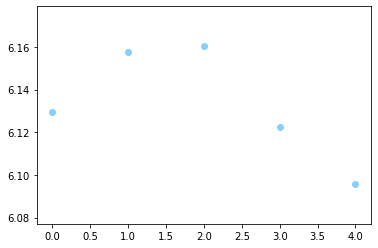

In [22]:
plt.scatter(
            x = avg_price_dayofweek['dayofweek'],
            y = avg_price_dayofweek['adj_close'],c='LightSkyBlue')

In [23]:
# Create lags 
df_lags = add_lags(df, N, ['adj_close'])
df_lags

,adj_close,date,year,month,week,day,dayofweek,dayofyear,is_month_end,is_month_start,...,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,adj_close_lag_4,adj_close_lag_5,adj_close_lag_6,adj_close_lag_7,adj_close_lag_8,adj_close_lag_9,adj_close_lag_10
0,2.75,2014-01-02,0,1,1,2,3,2,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.70,2014-01-03,0,1,1,3,4,3,False,False,...,2.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.60,2014-01-06,0,1,2,6,0,6,False,False,...,2.70,2.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.61,2014-01-07,0,1,2,7,1,7,False,False,...,2.60,2.70,2.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.60,2014-01-08,0,1,2,8,2,8,False,False,...,2.61,2.60,2.70,2.75,NaN,NaN,NaN,NaN,NaN,NaN
5,2.58,2014-01-09,0,1,2,9,3,9,False,False,...,2.60,2.61,2.60,2.70,2.75,NaN,NaN,NaN,NaN,NaN
6,2.50,2014-01-10,0,1,2,10,4,10,False,False,...,2.58,2.60,2.61,2.60,2.70,2.75,NaN,NaN,NaN,NaN
7,2.51,2014-01-13,0,1,3,13,0,13,False,False,...,2.50,2.58,2.60,2.61,2.60,2.70,2.75,NaN,NaN,NaN
8,2.53,2014-01-14,0,1,3,14,1,14,False,False,...,2.51,2.50,2.58,2.60,2.61,2.60,2.70,2.75,NaN,NaN
9,2.51,2014-01-15,0,1,3,15,2,15,False,False,...,2.53,2.51,2.50,2.58,2.60,2.61,2.60,2.70,2.75,NaN


In [24]:
# Compute correlation
features = [
        'adj_close',
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end',
        'is_year_start'
]
for n in range(N,0,-1):
    features.append("adj_close_lag_"+str(n))
        
corr_matrix = df_lags[features].corr()
corr_matrix["adj_close"].sort_values(ascending=False)

adj_close           1.000000
adj_close_lag_1     0.993351
adj_close_lag_2     0.986210
adj_close_lag_3     0.979832
adj_close_lag_4     0.972746
adj_close_lag_5     0.964962
adj_close_lag_6     0.957472
adj_close_lag_7     0.950701
adj_close_lag_8     0.945366
adj_close_lag_9     0.938966
adj_close_lag_10    0.931616
year                0.267001
month               0.043597
week                0.042958
dayofyear           0.042020
is_month_start      0.017636
is_year_end         0.005111
is_month_end        0.004779
is_quarter_start    0.002213
is_quarter_end     -0.003039
dayofweek          -0.007587
day                -0.014799
is_year_start            NaN
Name: adj_close, dtype: float64

In [25]:
# Plot correlation for lag features only
features = ['adj_close']
for n in range(1,N+1,1):
    features.append("adj_close_lag_"+str(n))
        
corr_matrix = df_lags[features].corr()

下面的热力图显示了经复权后的前几日收盘价与当日收盘价的相关性。很明显，经复权后的收盘价越接近当日，它们之间的相关性就越高。因此，在预测中应该使用与前10天复权收盘价相关的特征

In [26]:
import seaborn as sns

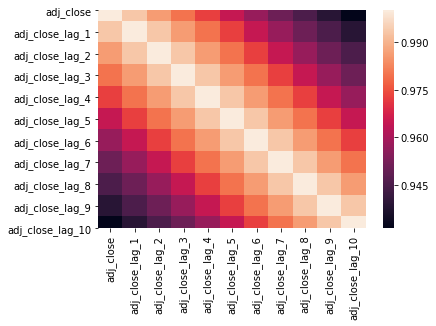

In [27]:
sns.heatmap(corr_matrix)

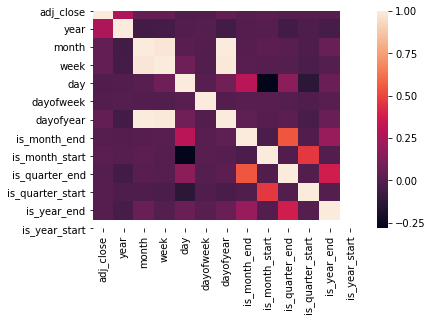

In [28]:
# Plot correlation for date features only
features = [
        'adj_close',
        'year',
        'month',
        'week',
        'day',
        'dayofweek',
        'dayofyear',
        'is_month_end',
        'is_month_start',
        'is_quarter_end',
        'is_quarter_start',
        'is_year_end',
        'is_year_start'
]
        
corr_matrix = df_lags[features].corr()
sns.heatmap(corr_matrix)

# Split into train, validation, test

In [29]:
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, df.iloc[pred_day]['date'], H))

Predicting on day 1008, date 2018-03-13 00:00:00, with forecast horizon H = 21


In [30]:
train = df[pred_day-train_val_size:pred_day-val_size].copy()
val = df[pred_day-val_size:pred_day].copy()
train_val = df[pred_day-train_val_size:pred_day].copy()
test = df[pred_day:pred_day+H].copy()
print("train.shape = " + str(train.shape))
print("val.shape = " + str(val.shape))
print("train_val.shape = " + str(train_val.shape))
print("test.shape = " + str(test.shape))

train.shape = (756, 14)
val.shape = (252, 14)
train_val.shape = (1008, 14)
test.shape = (21, 14)


# Predict for a specific H (forecast horizon) and a specific date

In [31]:
# Get error metrics on validation set before hyperparameter tuning
rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning, preds_dict = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        N,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators,
                                                                        max_depth=max_depth,
                                                                        learning_rate=learning_rate,
                                                                        min_child_weight=min_child_weight,
                                                                        subsample=subsample,
                                                                        colsample_bytree=colsample_bytree,
                                                                        colsample_bylevel=colsample_bylevel,
                                                                        gamma=gamma)
print("RMSE = %0.3f" % rmse_bef_tuning)
print("MAPE = %0.3f%%" % mape_bef_tuning)
print("MAE = %0.3f%%" % mae_bef_tuning)

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



RMSE = 0.327
MAPE = 3.788%
MAE = 0.281%


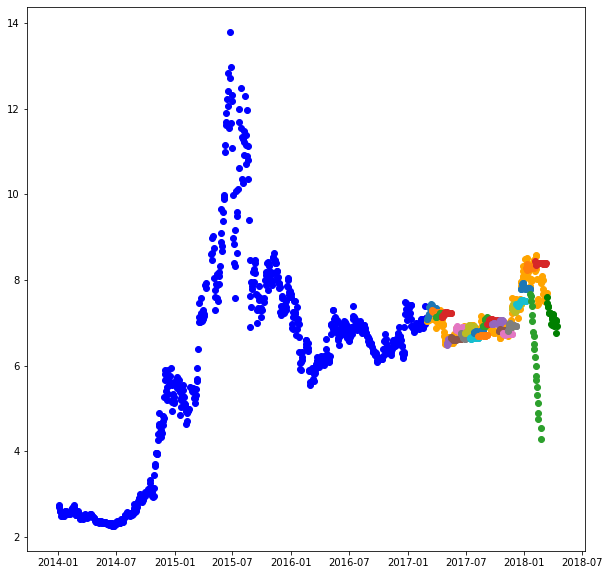

In [38]:
plt.figure(figsize=(10, 10))
plt.scatter(x=train['date'], y=train['adj_close'], c = 'blue')
plt.scatter(x=val['date'], y=val['adj_close'], c = 'orange')
plt.scatter(x=test['date'], y=test['adj_close'], c = 'green')

# Plot the predictions
n = 0
for key in preds_dict:
    plt.scatter(x=train_val[key:key+H]['date'], 
                             y=preds_dict[key], c = colors[n%len(colors)])
    n = n + 1

In [39]:
# Do prediction on test set
test_rmse_bef_tuning, test_mape_bef_tuning, test_mae_bef_tuning, est, feature_importances, features = \
                                            get_error_metrics_one_pred(df[pred_day-train_val_size:pred_day+H],
                                                                       train_size+val_size,
                                                                       N,
                                                                       H,
                                                                       seed=model_seed,
                                                                       n_estimators=n_estimators,
                                                                       max_depth=max_depth,
                                                                       learning_rate=learning_rate,
                                                                       min_child_weight=min_child_weight,
                                                                       subsample=subsample,
                                                                       colsample_bytree=colsample_bytree,
                                                                       colsample_bylevel=colsample_bylevel,
                                                                       gamma=gamma)

print("RMSE = %0.3f" % test_rmse_bef_tuning)
print("MAPE = %0.3f%%" % test_mape_bef_tuning)
print("MAE = %0.3f" % test_mae_bef_tuning)

RMSE = 0.511
MAPE = 6.730%
MAE = 0.476


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



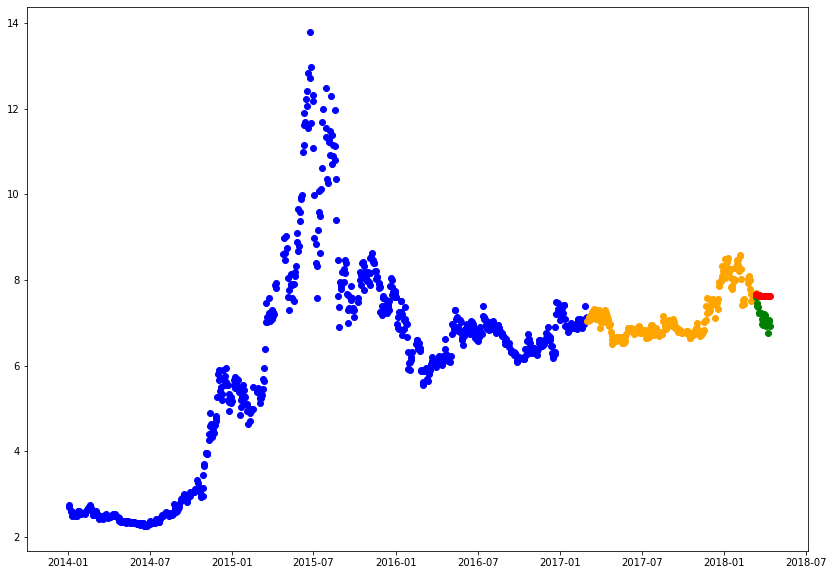

In [42]:
plt.figure(figsize=(14, 10))
plt.scatter(x=train['date'], y=train['adj_close'], c = 'blue')
plt.scatter(x=val['date'], y=val['adj_close'], c = 'orange')
plt.scatter(x=test['date'], y=test['adj_close'], c = 'green')
plt.scatter(x=test[:H]['date'], 
                         y=est, c = 'red')

In [43]:
# View a list of the features and their importance scores
imp = list(zip(features, feature_importances))
imp.sort(key=lambda tup: tup[1], reverse=False) 
imp

[('is_month_end', 0.0),
 ('is_month_start', 0.0),
 ('is_quarter_end', 0.0),
 ('is_quarter_start', 0.0),
 ('is_year_end', 0.0),
 ('month', 0.012539439),
 ('year', 0.01335225),
 ('adj_close_scaled_lag_8', 0.022834891),
 ('adj_close_scaled_lag_9', 0.024318047),
 ('dayofweek', 0.02727642),
 ('day', 0.027621485),
 ('adj_close_scaled_lag_3', 0.027666086),
 ('week', 0.028197527),
 ('adj_close_scaled_lag_4', 0.028445564),
 ('adj_close_scaled_lag_2', 0.033762723),
 ('adj_close_scaled_lag_7', 0.034925107),
 ('dayofyear', 0.039440032),
 ('adj_close_scaled_lag_5', 0.041529946),
 ('adj_close_scaled_lag_10', 0.06618837),
 ('adj_close_scaled_lag_6', 0.09578142),
 ('adj_close_scaled_lag_1', 0.4761207)]

# Predict for a specific H (forecast horizon) and a specific date, with hyperparam tuning

In [44]:
# We use a constant for N here
N_opt = N

## Tuning n_estimators (default=100) and max_depth (default=3)

In [45]:
param_label = 'n_estimators'
param_list = range(1, 61, 2)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=param,
                                                              max_depth=param2,
                                                              learning_rate=learning_rate,
                                                              min_child_weight=min_child_weight,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   


Minutes taken = 14.53


,n_estimators,max_depth,rmse,mape,mae
0,1,2,0.258318,3.049959,0.221944
1,1,3,0.257886,3.043825,0.221514
2,1,4,0.258045,3.045497,0.221707
3,1,5,0.258236,3.049124,0.221946
4,1,6,0.258779,3.056474,0.222503
5,1,7,0.258836,3.057511,0.222588
6,1,8,0.258559,3.053251,0.222301
7,1,9,0.258687,3.055641,0.222451
8,3,2,0.256362,3.018487,0.219813
9,3,3,0.255584,3.010220,0.219231


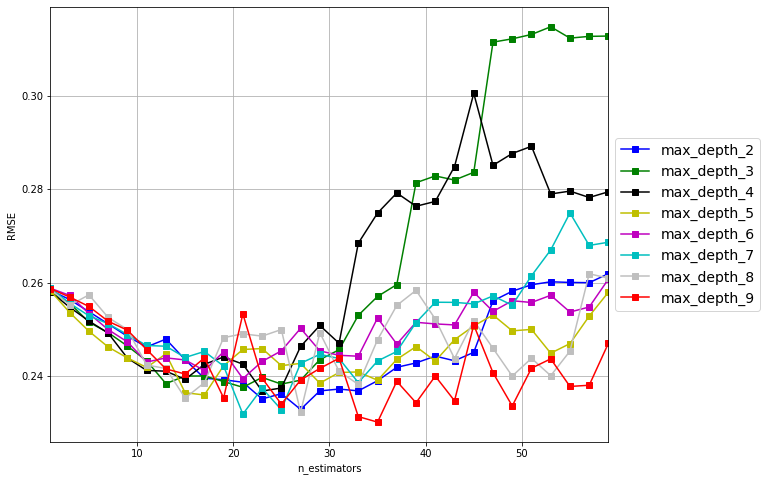

In [46]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 20])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [47]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 0.230
optimum params = 


(35, 9)

In [48]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 2.671%
optimum params = 


(27, 2)

## Tuning learning_rate(default=0.1) and min_child_weight(default=1)

In [49]:
param_label = 'learning_rate'
param_list = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=param,
                                                              min_child_weight=param2,
                                                              subsample=subsample,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   


Minutes taken = 8.36


,learning_rate,min_child_weight,rmse,mape,mae
0,0.0001,5,0.259656,3.068667,0.223248
1,0.0001,6,0.259660,3.068735,0.223253
2,0.0001,7,0.259630,3.068317,0.223223
3,0.0001,8,0.259644,3.068461,0.223235
4,0.0001,9,0.259627,3.068255,0.223218
5,0.0001,10,0.259637,3.068449,0.223232
6,0.0001,11,0.259623,3.068260,0.223217
7,0.0001,12,0.259617,3.068245,0.223216
8,0.0001,13,0.259635,3.068489,0.223234
9,0.0001,14,0.259639,3.068514,0.223236


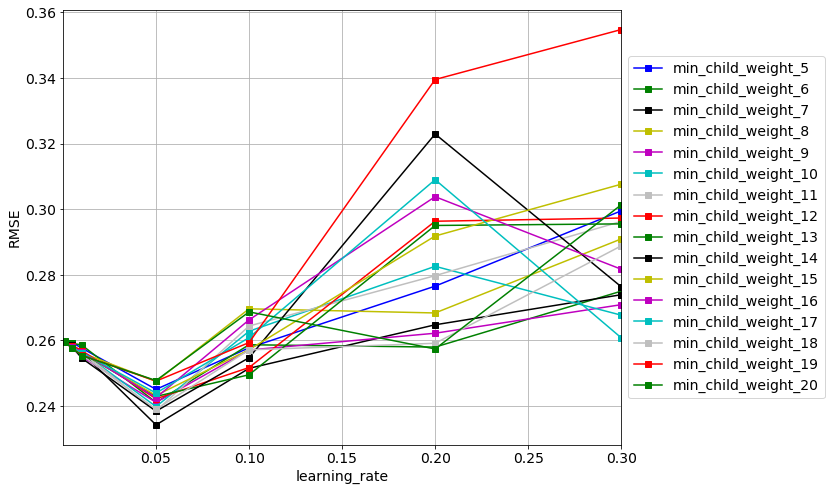

In [50]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
# ax.set_ylim([0, 4])
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [51]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 0.234
optimum params = 


(0.05, 7)

In [52]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 2.704%
optimum params = 


(0.05, 7)

## Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [53]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=param,
                                                              colsample_bytree=colsample_bytree,
                                                              colsample_bylevel=colsample_bylevel,
                                                              gamma=param2)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   


Minutes taken = 7.48


,subsample,gamma,rmse,mape,mae
0,0.1,0.0,0.244181,2.837079,0.206947
1,0.1,0.1,0.245893,2.858105,0.208412
2,0.1,0.2,0.242853,2.822962,0.205712
3,0.1,0.3,0.242066,2.807508,0.204804
4,0.1,0.4,0.244336,2.838071,0.206787
5,0.1,0.5,0.242712,2.815038,0.205146
6,0.1,0.6,0.241630,2.798131,0.204045
7,0.1,0.7,0.241357,2.793953,0.203726
8,0.1,0.8,0.242016,2.805433,0.204588
9,0.1,0.9,0.241740,2.798293,0.204211


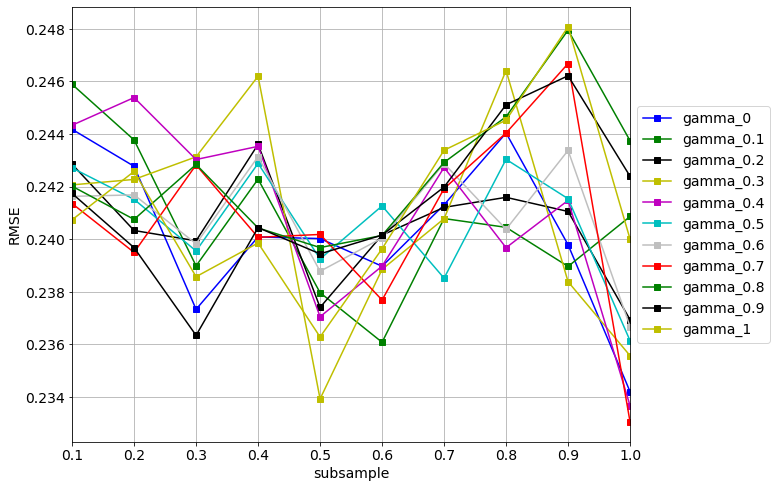

In [54]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [55]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 0.233
optimum params = 


(1.0, 0.7)

In [56]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 2.682%
optimum params = 


(0.5, 0.3)

## Tuning colsample_bytree(default=1) and colsample_bylevel(default=1)

In [57]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = defaultdict(list)

tic = time.time()
for param in tqdm_notebook(param_list):    
    for param2 in param2_list:
        rmse_mean, mape_mean, mae_mean, _ = get_error_metrics(train_val,
                                                              train_size,
                                                              N_opt,
                                                              H,
                                                              seed=model_seed,
                                                              n_estimators=n_estimators_opt,
                                                              max_depth=max_depth_opt,
                                                              learning_rate=learning_rate_opt,
                                                              min_child_weight=min_child_weight_opt,
                                                              subsample=subsample_opt,
                                                              colsample_bytree=param,
                                                              colsample_bylevel=param2,
                                                              gamma=gamma_opt)

    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse_mean)
        error_rate['mape'].append(mape_mean)
        error_rate['mae'].append(mae_mean)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = {0:.2f}".format((toc-tic)/60.0))

error_rate   


Minutes taken = 2.36


,colsample_bytree,colsample_bylevel,rmse,mape,mae
0,0.5,0.5,0.238434,2.747589,0.200939
1,0.5,0.6,0.240149,2.753002,0.201348
2,0.5,0.7,0.240712,2.761270,0.201829
3,0.5,0.8,0.238807,2.742781,0.200290
4,0.5,0.9,0.241363,2.780537,0.203229
5,0.5,1.0,0.239736,2.765813,0.202333
6,0.6,0.5,0.239084,2.749305,0.201210
7,0.6,0.6,0.239626,2.749607,0.200587
8,0.6,0.7,0.237785,2.713281,0.198324
9,0.6,0.8,0.237767,2.729760,0.199351


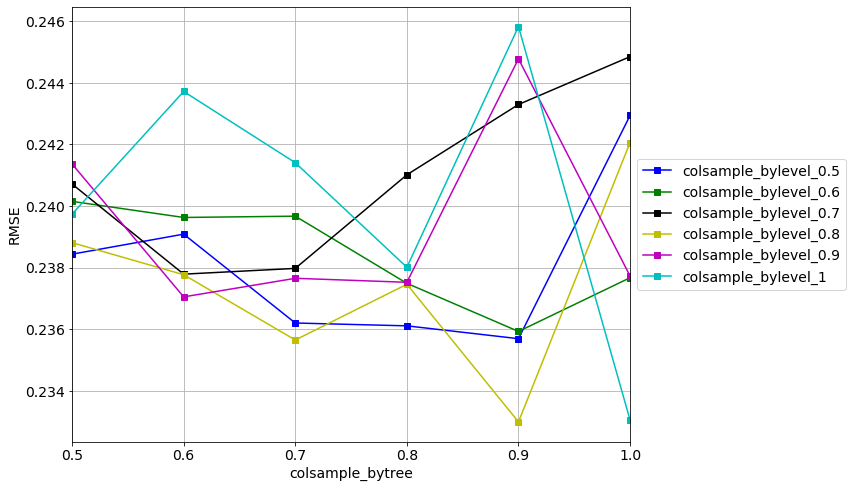

In [58]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [59]:
# Get optimum value for param and param2, using RMSE
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 0.233
optimum params = 


(0.9, 0.8)

In [60]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 2.679%
optimum params = 


(0.9, 0.8)

## Final model

In [61]:
# Get error metrics on validation set after hyperparameter tuning
rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning, preds_dict = \
                                                      get_error_metrics(train_val,
                                                                        train_size,
                                                                        N_opt,
                                                                        H,
                                                                        seed=model_seed,
                                                                        n_estimators=n_estimators_opt,
                                                                        max_depth=max_depth_opt,
                                                                        learning_rate=learning_rate_opt,
                                                                        min_child_weight=min_child_weight_opt,
                                                                        subsample=subsample_opt,
                                                                        colsample_bytree=colsample_bytree_opt,
                                                                        colsample_bylevel=colsample_bylevel_opt,
                                                                        gamma=gamma_opt)
print("RMSE = %0.3f" % rmse_aft_tuning)
print("MAPE = %0.3f%%" % mape_aft_tuning)
print("MAE = %0.3f" % mae_aft_tuning)

RMSE = 0.233
MAPE = 2.679%
MAE = 0.196


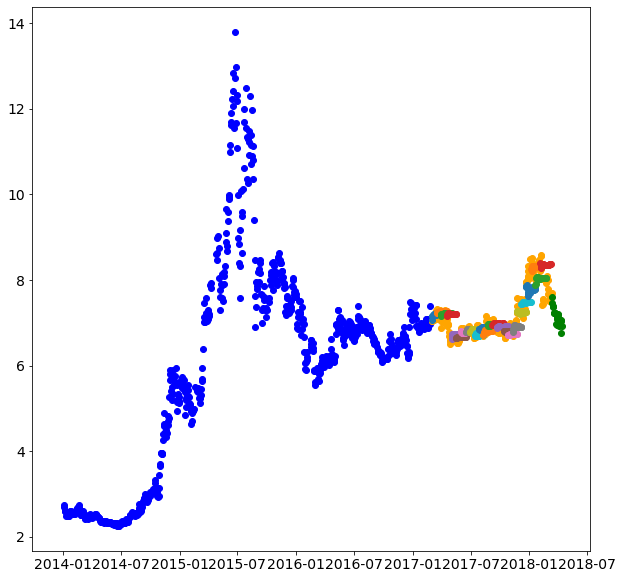

In [74]:
plt.figure(figsize=(10, 10))
plt.scatter(x=train['date'], y=train['adj_close'], c = 'blue')
plt.scatter(x=val['date'], y=val['adj_close'], c = 'orange')
plt.scatter(x=test['date'], y=test['adj_close'], c = 'green')

# Plot the predictions
n = 0
for key in preds_dict:
    plt.scatter(x=train_val[key:key+H]['date'], 
                             y=preds_dict[key], c = colors[n%len(colors)])
    n = n + 1

In [75]:
# Do prediction on test set
test_rmse_aft_tuning, test_mape_aft_tuning, test_mae_aft_tuning, est, feature_importances, features = \
                                            get_error_metrics_one_pred(df[pred_day-train_val_size:pred_day+H],
                                                                       train_size+val_size,
                                                                       N_opt,
                                                                       H,
                                                                       seed=model_seed,
                                                                       n_estimators=n_estimators_opt,
                                                                       max_depth=max_depth_opt,
                                                                       learning_rate=learning_rate_opt,
                                                                       min_child_weight=min_child_weight_opt,
                                                                       subsample=subsample_opt,
                                                                       colsample_bytree=colsample_bytree_opt,
                                                                       colsample_bylevel=colsample_bylevel_opt,
                                                                       gamma=gamma_opt)


print("RMSE = %0.3f" % test_rmse_aft_tuning)
print("MAPE = %0.3f%%" % test_mape_aft_tuning)
print("MAE = %0.3f" % test_mae_aft_tuning)

RMSE = 0.545
MAPE = 7.206%
MAE = 0.510


/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/Users/luoyonggui/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



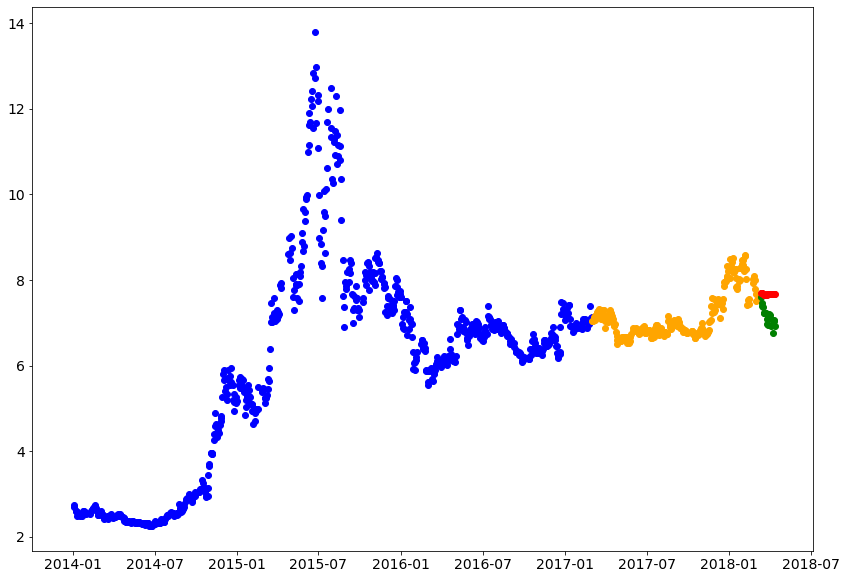

In [76]:
plt.figure(figsize=(14, 10))
plt.scatter(x=train['date'], y=train['adj_close'], c = 'blue')
plt.scatter(x=val['date'], y=val['adj_close'], c = 'orange')
plt.scatter(x=test['date'], y=test['adj_close'], c = 'green')
plt.scatter(x=test[:H]['date'], 
                         y=est, c = 'red')

In [77]:
# View a list of the features and their importance scores
imp = list(zip(features, feature_importances))
imp.sort(key=lambda tup: tup[1], reverse=False) 
imp

[('is_month_end', 0.0),
 ('is_month_start', 0.0),
 ('is_quarter_end', 0.0),
 ('is_quarter_start', 0.0),
 ('is_year_end', 0.0),
 ('dayofweek', 0.024169939),
 ('day', 0.028030572),
 ('dayofyear', 0.031084243),
 ('year', 0.031701427),
 ('week', 0.038936075),
 ('month', 0.039105907),
 ('adj_close_scaled_lag_3', 0.039818544),
 ('adj_close_scaled_lag_8', 0.04032189),
 ('adj_close_scaled_lag_7', 0.04039654),
 ('adj_close_scaled_lag_9', 0.04133178),
 ('adj_close_scaled_lag_10', 0.043962862),
 ('adj_close_scaled_lag_5', 0.04769617),
 ('adj_close_scaled_lag_4', 0.047769185),
 ('adj_close_scaled_lag_6', 0.05371544),
 ('adj_close_scaled_lag_2', 0.1183235),
 ('adj_close_scaled_lag_1', 0.33363593)]

<BarContainer object of 10 artists>

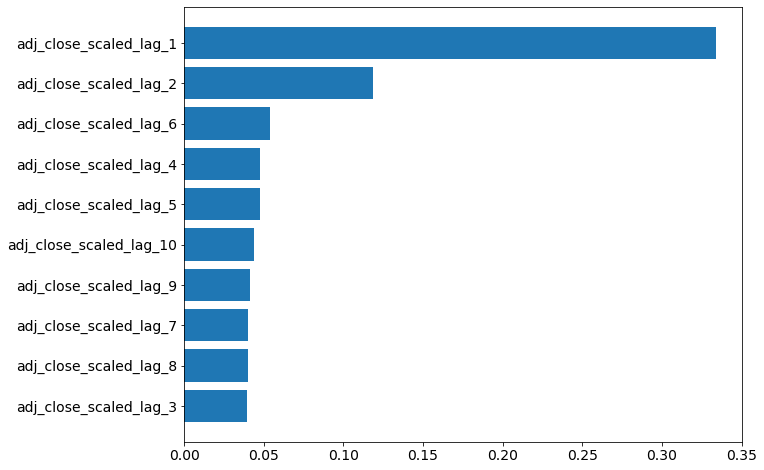

In [81]:
plt.barh([item[0] for item in imp[-10:]],[item[1] for item in imp[-10:]],)

## Tuned params

In [82]:
# Tuned params and before and after error metrics
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'val_rmse', 'val_mape', 'val_mae'],
     'before_tuning': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning, mae_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, rmse_aft_tuning, mape_aft_tuning, mae_aft_tuning]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,before_tuning,after_tuning
0,n_estimators,100.000,35.000
1,max_depth,3.000,9.000
2,learning_rate,0.100,0.050
3,min_child_weight,1.000,7.000
4,subsample,1.000,1.000
5,colsample_bytree,1.000,0.900
6,colsample_bylevel,1.000,0.800
7,gamma,0.000,0.700
8,val_rmse,0.327,0.233
9,val_mape,3.788,2.679


In [1118]:
# Put tuned_params into pickle
pickle.dump(tuned_params, open("./out/v6d_tuned_params_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))

In [1119]:
# pickle.load(open("./out/v6d_tuned_params_" + "2017-03-06" + ".pickle", "rb"))

In [83]:
toc1 = time.time()
print("Total minutes taken = {0:.2f}".format((toc1-tic1)/60.0))

Total minutes taken = 1598.36


# Findings

In [84]:
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (pred_day, df.iloc[pred_day]['date'].strftime("%Y-%m-%d"), H))

Predicting on day 1008, date 2018-03-13, with forecast horizon H = 21


In [85]:
rmse_bef_tuning, rmse_aft_tuning

(0.32674994309457106, 0.23298566229564)

In [86]:
test_rmse_bef_tuning, test_rmse_aft_tuning

(0.5112523772265237, 0.5448814414256512)

In [1124]:
# Put results into pickle
pickle.dump(rmse_bef_tuning, open("./out/v6d_val_rmse_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(rmse_aft_tuning, open("./out/v6d_val_rmse_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_rmse_bef_tuning, open("./out/v6d_test_rmse_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mape_bef_tuning, open("./out/v6d_test_mape_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mae_bef_tuning, open("./out/v6d_test_mae_bef_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_rmse_aft_tuning, open("./out/v6d_test_rmse_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mape_aft_tuning, open("./out/v6d_test_mape_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(test_mae_aft_tuning, open("./out/v6d_test_mae_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))
pickle.dump(est, open("./out/v6d_test_est_aft_tuning_" + df.iloc[pred_day]['date'].strftime("%Y-%m-%d") + ".pickle", "wb"))

In [1125]:
# Consolidate results
# H = 21                         # Forecast horizon, in days. Note there are about 252 trading days in a year
# train_size = 252*3             # Use 3 years of data as train set. Note there are about 252 trading days in a year
# val_size = 252                 # Use 1 year of data as validation set
# N = 10                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
results = defaultdict(list)
ests = {} # the predictions
date_list = ['2017-01-03',
             '2017-03-06',
             '2017-05-04',
             '2017-07-05',
             '2017-09-01',
             '2017-11-01',
             '2018-01-03',
             '2018-03-06',
             '2018-05-04',
             '2018-07-05',
             '2018-09-04',
             '2018-11-01'
            ]
for date in date_list:
    results['date'].append(date)
    results['val_rmse_bef_tuning'].append(pickle.load(open( "./out/v6d_val_rmse_bef_tuning_" + date + ".pickle", "rb")))
    results['val_rmse_aft_tuning'].append(pickle.load(open( "./out/v6d_val_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results['test_rmse_bef_tuning'].append(pickle.load(open( "./out/v6d_test_rmse_bef_tuning_" + date + ".pickle", "rb")))
    results['test_rmse_aft_tuning'].append(pickle.load(open( "./out/v6d_test_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results['test_mape_bef_tuning'].append(pickle.load(open( "./out/v6d_test_mape_bef_tuning_" + date + ".pickle", "rb")))
    results['test_mape_aft_tuning'].append(pickle.load(open( "./out/v6d_test_mape_aft_tuning_" + date + ".pickle", "rb")))
    results['test_mae_bef_tuning'].append(pickle.load(open( "./out/v6d_test_mae_bef_tuning_" + date + ".pickle", "rb")))
    results['test_mae_aft_tuning'].append(pickle.load(open( "./out/v6d_test_mae_aft_tuning_" + date + ".pickle", "rb")))
    ests[date] = pickle.load(open( "./out/v6d_test_est_aft_tuning_" + date + ".pickle", "rb"))
    
results = pd.DataFrame(results)
results

,date,val_rmse_bef_tuning,val_rmse_aft_tuning,test_rmse_bef_tuning,test_rmse_aft_tuning,test_mape_bef_tuning,test_mape_aft_tuning,test_mae_bef_tuning,test_mae_aft_tuning
0,2017-01-03,2.181505,1.929410,2.519491,1.491535,2.160085,1.227341,2.441806,1.388315
1,2017-03-06,1.859381,1.748119,1.742705,1.522797,1.339765,1.147115,1.566619,1.340978
2,2017-05-04,1.858766,1.683178,1.010223,0.895876,0.654931,0.553540,0.783453,0.661084
3,2017-07-05,1.807501,1.445085,1.894902,1.732334,1.358432,1.236195,1.673756,1.522898
4,2017-09-01,1.519419,1.342027,1.763289,1.754289,1.228387,1.217536,1.541311,1.527847
5,2017-11-01,1.630659,1.455721,1.410441,1.270258,0.754857,0.677038,0.990699,0.888327
6,2018-01-03,1.605918,1.548056,48.019891,5.114899,19.638232,3.334857,27.908289,4.713266
7,2018-03-06,2.272263,2.147067,4.884154,3.439315,2.896468,2.123761,3.875790,2.857635
8,2018-05-04,9.059502,2.293339,3.443149,4.221913,2.402376,2.950227,3.324304,4.082444
9,2018-07-05,2.820809,2.478181,3.470080,3.948716,2.328910,2.666547,3.342034,3.825811


In [1126]:
# Generate a condensed dataframe of the above
results_short = defaultdict(list)
hyperparam_list = ['n_estimators', 
                   'max_depth', 
                   'learning_rate', 
                   'min_child_weight',
#                    'subsample',
#                    'colsample_bytree',
#                    'colsample_bylevel',
#                    'gamma'
                  ]

for date in date_list:
    results_short['date'].append(date)
    results_short['RMSE'].append(pickle.load(open( "./out/v6d_test_rmse_aft_tuning_" + date + ".pickle", "rb")))
    results_short['MAPE(%)'].append(pickle.load(open( "./out/v6d_test_mape_aft_tuning_" + date + ".pickle", "rb")))
    results_short['MAE'].append(pickle.load(open( "./out/v6d_test_mae_aft_tuning_" + date + ".pickle", "rb")))
    
    tuned_params = pickle.load(open("./out/v6d_tuned_params_" + date + ".pickle", "rb"))
    for hyperparam in hyperparam_list:
        results_short[hyperparam].append(tuned_params[tuned_params['param']==hyperparam]['after_tuning'].values[0])

    
results_short = pd.DataFrame(results_short)
results_short

,date,RMSE,MAPE(%),MAE,n_estimators,max_depth,learning_rate,min_child_weight
0,2017-01-03,1.491535,1.227341,1.388315,33.0,3.0,0.20,15.0
1,2017-03-06,1.522797,1.147115,1.340978,11.0,9.0,0.30,11.0
2,2017-05-04,0.895876,0.553540,0.661084,13.0,7.0,0.30,6.0
3,2017-07-05,1.732334,1.236195,1.522898,21.0,7.0,0.10,13.0
4,2017-09-01,1.754289,1.217536,1.527847,37.0,7.0,0.10,11.0
5,2017-11-01,1.270258,0.677038,0.888327,39.0,7.0,0.20,18.0
6,2018-01-03,5.114899,3.334857,4.713266,7.0,9.0,0.30,17.0
7,2018-03-06,3.439315,2.123761,2.857635,51.0,3.0,0.05,20.0
8,2018-05-04,4.221913,2.950227,4.082444,23.0,2.0,0.30,20.0
9,2018-07-05,3.948716,2.666547,3.825811,33.0,4.0,0.30,16.0


In [1127]:
results.mean()

val_rmse_bef_tuning     2.730394
val_rmse_aft_tuning     1.968402
test_rmse_bef_tuning    6.123052
test_rmse_aft_tuning    2.424110
test_mape_bef_tuning    3.056972
test_mape_aft_tuning    1.608046
test_mae_bef_tuning     4.180013
test_mae_aft_tuning     2.154893
dtype: float64

In [1128]:
# Plot all predictions
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df['date'], 
                         y=df['adj_close'],
                         mode='lines',
                         name='adj_close',
                         line=dict(color='blue')))

# Plot the predictions
n = 0
for key in ests:
    i = df[df['date']==key].index[0]
    fig.add_trace(go.Scatter(x=df[i:i+H]['date'], 
                             y=ests[key],
                             mode='lines',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.update_layout(yaxis=dict(title='USD'),
                  xaxis=dict(title='date'))
fig.update_xaxes(range=['2017-01-03', '2018-12-28'])
fig.update_yaxes(range=[110, 150])
py.iplot(fig, filename='StockPricePrediction_v6d_xgboost_predictions')

In [1129]:
# Plot scatter plot of actual values vs. predictions
fig = go.Figure()

n = 0
for key in ests:
    i = df[df['date']==key].index[0]
    fig.add_trace(go.Scatter(x=df[i:i+H]['adj_close'], 
                             y=ests[key],
                             mode='markers',
                             name='predictions',
                             line=dict(color=colors[n%len(colors)])))
    n = n + 1

fig.add_trace(go.Scatter(x=list(range(110, 155, 1)),
                         y=list(range(110, 155, 1)),
                         mode='lines',
                         name='actual values',
                         line=dict(color='blue')))

fig.update_layout(yaxis=dict(title='forecasts'),
                  xaxis=dict(title='adj_close'))
py.iplot(fig, filename='StockPricePrediction_v6d_xgboost_actuals_vs_predictions')

In [1131]:
# Compare results with benchmark
all_results = pd.DataFrame({'Method': ['Last value',  'XGBoost w/o date features', 'XGBoost w date features'],
                            'RMSE': [2.53, 2.32, 2.42],
                            'MAPE(%)': [1.69, 1.53, 1.61],
                            'MAE': [2.26, 2.05, 2.15]})
all_results

,Method,RMSE,MAPE(%),MAE
0,Last value,2.53,1.69,2.26
1,XGBoost w/o date features,2.32,1.53,2.05
2,XGBoost w date features,2.42,1.61,2.15
